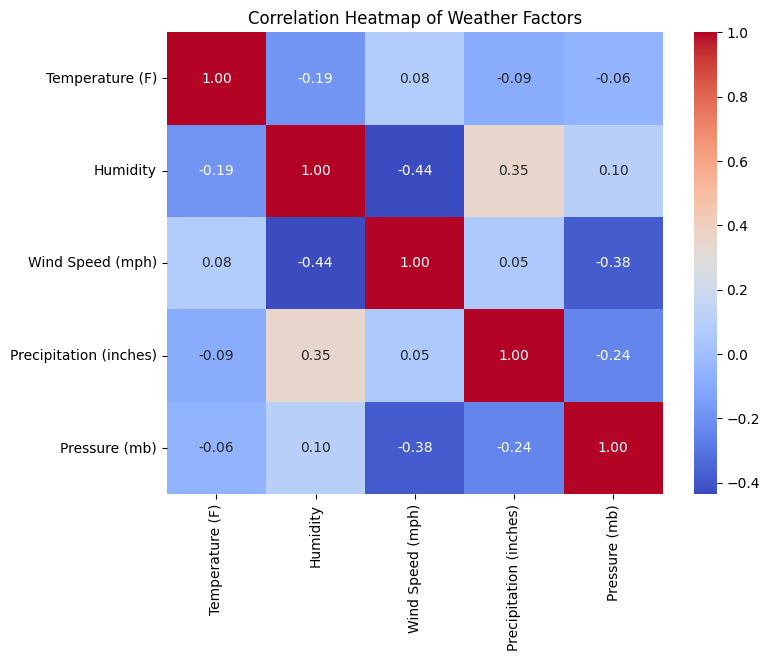

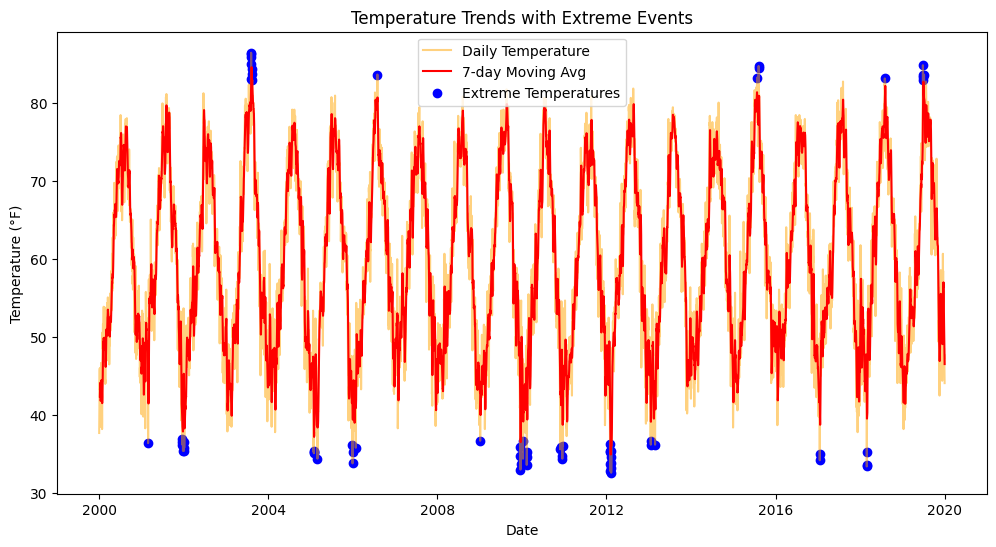

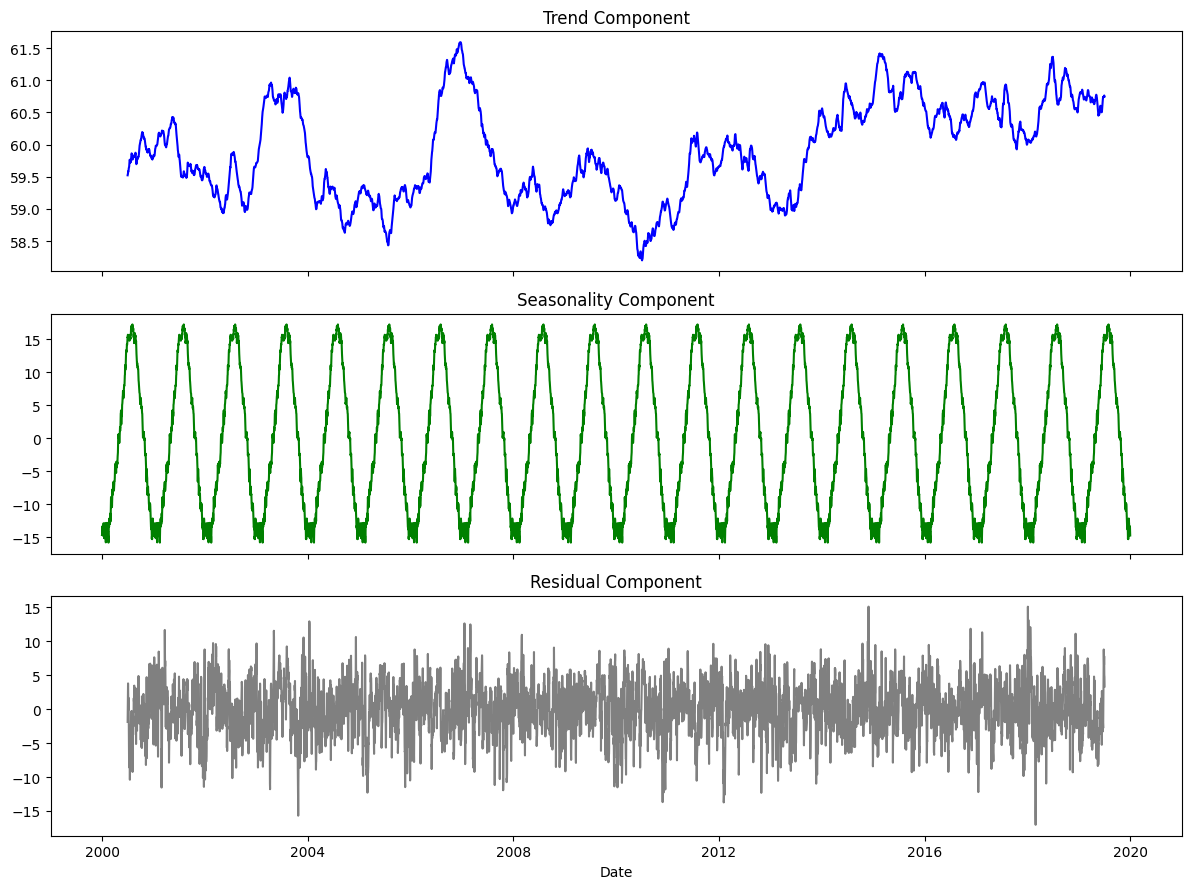

Extreme Temperature Events:
           Date  Temperature (F)  Humidity  Wind Speed (mph)  \
423  2001-02-27             36.4      78.6              19.9   
717  2001-12-18             36.6      69.2               7.3   
718  2001-12-19             36.9      66.5              11.4   
719  2001-12-20             36.2      61.7              14.0   
724  2001-12-25             35.4      50.5              13.4   
...         ...              ...       ...               ...   
7117 2019-06-27             84.9      55.9               9.8   
7118 2019-06-28             83.4      62.7               9.8   
7119 2019-06-29             83.0      64.6              10.3   
7120 2019-06-30             83.7      61.1              10.2   
7127 2019-07-07             83.7      59.8              13.8   

      Precipitation (inches)  Pressure (mb)  
423                    0.491         1003.0  
717                    0.002         1028.2  
718                    0.000         1027.5  
719                

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA

# Load the dataset
file_path = '../scraper/2000-2020-rexburg.csv'  # Replace with your CSV file path
data = pd.read_csv(file_path)

# Convert 'Date' to datetime
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    data['Date'] = pd.to_datetime(data['Date'])

# Sort data by date
data = data.sort_values(by='Date')

# Compute rolling averages for trend analysis
window_size = 7  # One-week rolling average
data['Temp_MA'] = data['Temperature (F)'].rolling(window=window_size).mean()
data['Humidity_MA'] = data['Humidity'].rolling(window=window_size).mean()
data['Wind_MA'] = data['Wind Speed (mph)'].rolling(window=window_size).mean()
data['Precip_MA'] = data['Precipitation (inches)'].rolling(window=window_size).mean()
data['Pressure_MA'] = data['Pressure (mb)'].rolling(window=window_size).mean()

# Detect extreme temperatures using z-score
z_scores = zscore(data['Temperature (F)'].dropna())
data['Temp_Z'] = np.abs(z_scores)

# Define extreme temperature threshold (e.g., z-score > 2)
extreme_threshold = 2
extreme_temps = data[data['Temp_Z'] > extreme_threshold]

# Correlation analysis
correlation_matrix = data[['Temperature (F)', 'Humidity', 'Wind Speed (mph)', 'Precipitation (inches)', 'Pressure (mb)']].corr()

# Seasonal decomposition
decomposed = seasonal_decompose(data['Temperature (F)'].dropna(), model='additive', period=365)
data['Trend'] = decomposed.trend
data['Seasonal'] = decomposed.seasonal
data['Residual'] = decomposed.resid

# Linear Regression Analysis
features = ['Humidity', 'Wind Speed (mph)', 'Precipitation (inches)', 'Pressure (mb)']
scaler = StandardScaler()
X = scaler.fit_transform(data[features].dropna())
y = data['Temperature (F)'].dropna()
model = LinearRegression()
model.fit(X, y)
coefficients = dict(zip(features, model.coef_))

# Random Forest Regressor for deeper analysis
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
feature_importances = dict(zip(features, rf_model.feature_importances_))

# ARIMA model for temperature forecasting
arima_model = ARIMA(data['Temperature (F)'].dropna(), order=(5,1,0))
arima_fit = arima_model.fit()
predictions = arima_fit.forecast(steps=7)

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Weather Factors')
plt.show()

# Plot temperature trends with moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Temperature (F)'], label='Daily Temperature', color='orange', alpha=0.5)
plt.plot(data['Date'], data['Temp_MA'], label='7-day Moving Avg', color='red')
plt.scatter(extreme_temps['Date'], extreme_temps['Temperature (F)'], color='blue', label='Extreme Temperatures', marker='o')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.title('Temperature Trends with Extreme Events')
plt.legend()
plt.show()

# Plot seasonal decomposition
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
axes[0].plot(data['Date'], data['Trend'], label='Trend', color='blue')
axes[0].set_title('Trend Component')
axes[1].plot(data['Date'], data['Seasonal'], label='Seasonality', color='green')
axes[1].set_title('Seasonality Component')
axes[2].plot(data['Date'], data['Residual'], label='Residual', color='gray')
axes[2].set_title('Residual Component')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Display extreme temperature occurrences
print("Extreme Temperature Events:")
print(extreme_temps[['Date', 'Temperature (F)', 'Humidity', 'Wind Speed (mph)', 'Precipitation (inches)', 'Pressure (mb)']])

# Conclusion based on factors
print("\nKey Observations:")
if correlation_matrix.loc['Temperature (F)', 'Humidity'] < -0.3:
    print("- High humidity may indicate lower temperatures.")
if correlation_matrix.loc['Temperature (F)', 'Wind Speed (mph)'] > 0.3:
    print("- Higher wind speeds might be linked to temperature fluctuations.")
if correlation_matrix.loc['Temperature (F)', 'Precipitation (inches)'] < -0.3:
    print("- Increased precipitation may correlate with colder temperatures.")
if correlation_matrix.loc['Temperature (F)', 'Pressure (mb)'] > 0.3:
    print("- High pressure could be associated with higher temperatures.")

print("\nLinear Regression Coefficients:")
for feature, coef in coefficients.items():
    print(f"- {feature}: {coef:.2f}")

print("\nRandom Forest Feature Importances:")
for feature, importance in feature_importances.items():
    print(f"- {feature}: {importance:.2f}")

print("\nTemperature Forecast for the Next 7 Days:")
print(predictions)

print("\nAnalysis complete. Visualizations displayed.")
